In [1]:
from unet_project.image_utils import ImageUtils
from unet_project.data_augmentation import DataAugmentation
from unet_project.u_net import Unet
from unet_project.create_patches import PatchesCreator
from skimage.io import imshow
from matplotlib import pyplot as plt
import numpy as np
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.signal import medfilt2d
from matplotlib import pyplot as plt
import random
from keras.models import load_model
from tqdm import tqdm_notebook
from time import time

Using TensorFlow backend.


In [2]:
path_to_imgs = '/home/ajuska/Dokumenty/Skola/diplomka/disk/imgs/'
path_to_masks = '/home/ajuska/Dokumenty/Skola/diplomka/disk/masks/'

# path_to_imgs = '/media/ubmi/DATA3/rozhonova/data/disk_data/imgs/'
# path_to_masks = '/media/ubmi/DATA3/rozhonova/data/disk_data/masks/'

img_height = 224
img_width = 224
img_channels = 3

image_utils = ImageUtils(path_to_imgs, path_to_masks, img_height, img_width, architecture='unet')
imgs_masks = image_utils.get_preprocessed_images()

#data_augmentor = DataAugmentation(imgs_masks, how_many=1)
#aug_imgs, aug_masks = data_augmentor.extend_database()

imgs = []
masks = []
for key, val in tqdm_notebook(imgs_masks.items()):
    imgs.append(val[0])
    masks.append(val[1])
    
    
resized_imgs = [cv2.resize(x, (img_height, img_width)) for x in imgs]
resized_masks = [cv2.resize(x, (img_height, img_width)) for x in masks]

train_imgs = resized_imgs[:int(0.85*len(resized_imgs))]
train_masks = resized_masks[:int(0.85*len(resized_masks))]

test_imgs = resized_imgs[int(0.85*len(resized_imgs)):]
test_masks = resized_masks[int(0.85*len(resized_masks)):]

#patches_creator = PatchesCreator(train_imgs, train_masks, img_height, img_width)
#img_p, mask_p = patches_creator.create_patches()

  4%|▎         | 6/162 [00:00<00:02, 54.77it/s]

Loading images.


100%|██████████| 162/162 [00:02<00:00, 59.84it/s]



Loading masks.


  1%|          | 1/162 [00:00<00:26,  6.18it/s]


Preprocessing images.


100%|██████████| 162/162 [00:01<00:00, 106.21it/s]


In [3]:
trainX = np.array([x/255 for x in train_imgs])
trainY = np.array([np.expand_dims(x/255 , axis=-1) for x in train_masks])

In [4]:
trainX.shape

(137, 224, 224, 3)

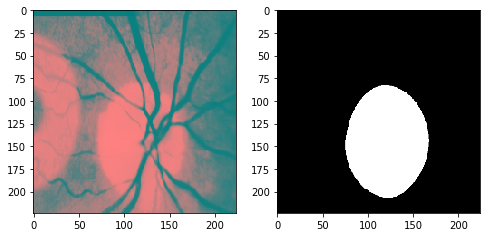

In [6]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(trainX[22], cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(trainY[22]), cmap='gray')

In [7]:
%%time
unet = Unet(img_height=img_height, img_width=img_width, img_channels=img_channels)
model = unet.create_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_unet_disk.h5', verbose=1, save_best_only=True)
results = model.fit(trainX, trainY, validation_split=0.1, batch_size=32, epochs=100,
                    callbacks=[earlystopper, checkpointer])

Creating model.
Train on 123 samples, validate on 14 samples
Epoch 1/100
123/123 [==============================] - 143s 1s/step - loss: 0.6935 - acc: 0.6216 - val_loss: 0.4825 - val_acc: 0.7976

Epoch 00001: val_loss improved from inf to 0.48250, saving model to model_unet_disk.h5
Epoch 2/100
123/123 [==============================] - 212s 2s/step - loss: 0.5202 - acc: 0.7838 - val_loss: 0.4752 - val_acc: 0.7987

Epoch 00002: val_loss improved from 0.48250 to 0.47520, saving model to model_unet_disk.h5
Epoch 3/100
123/123 [==============================] - 95s 772ms/step - loss: 0.5058 - acc: 0.7938 - val_loss: 0.4696 - val_acc: 0.7990

Epoch 00003: val_loss improved from 0.47520 to 0.46961, saving model to model_unet_disk.h5
Epoch 4/100
123/123 [==============================] - 97s 785ms/step - loss: 0.4959 - acc: 0.7969 - val_loss: 0.4649 - val_acc: 0.7992

Epoch 00004: val_loss improved from 0.46961 to 0.46493, saving model to model_unet_disk.h5
Epoch 5/100
123/123 [==============

In [8]:
# serialize model to JSON
model_json = model.to_json()
with open("model_unet_disk_lab.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_unet_disk_lab.h5")
print("Saved model to disk")

Saved model to disk


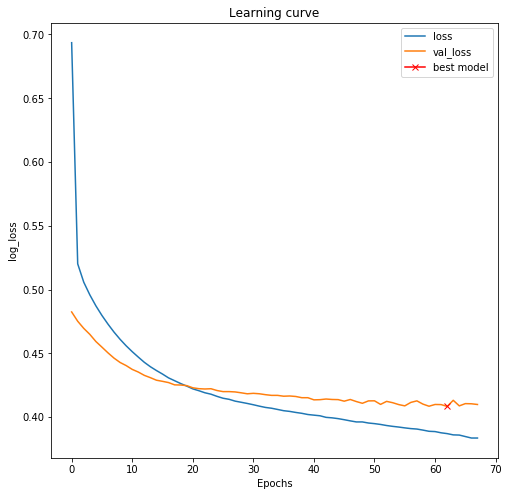

In [9]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Evaluation `

In [10]:
testX = np.array([x/255 for x in test_imgs])
testY = np.array([np.expand_dims(x/255 , axis=-1) for x in test_masks])

In [11]:
scores = model.evaluate(testX, testY, verbose=1)

25/25 [==============================] - 5s 197ms/step


In [12]:
print('Model loss = {}'.format(scores[0]))
print('Model accuracy = {}'.format(scores[1]))

Model loss = 0.37861621379852295
Model accuracy = 0.86366868019104


## Test on unseen data

In [13]:
preds = model.predict(testX)

In [16]:
preds_t = (preds > 0.09)
prediction = np.squeeze(preds_t*1)

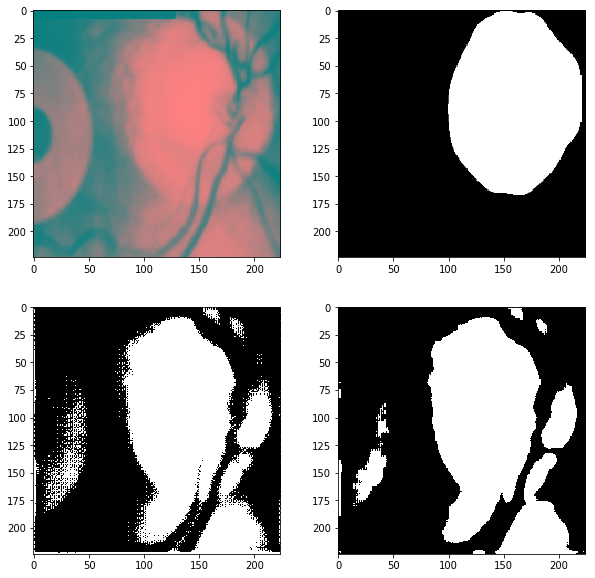

In [17]:
idx = 10

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(testX[idx])
plt.subplot(222)
plt.imshow(np.squeeze(testY[idx]), cmap='gray')
plt.subplot(223)
plt.imshow(prediction[idx], cmap='gray')
plt.subplot(224)
plt.imshow(medfilt2d(prediction[idx].astype(np.uint8), 5), cmap='gray')

## Post Processing

In [18]:
from skimage import data, color
from skimage.transform import hough_ellipse
from skimage.feature import canny
from skimage.draw import ellipse_perimeter
from skimage.util import img_as_ubyte

In [19]:
test_img_filtered = medfilt2d(prediction[idx].astype(np.uint8), 5)

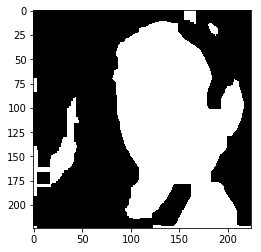

In [20]:
kernel = np.ones((12,12),np.uint8)
closing = cv2.morphologyEx(test_img_filtered, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

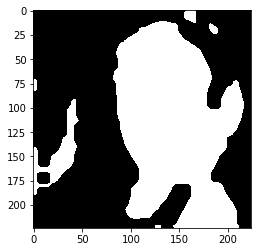

In [21]:
# opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
opening = medfilt2d(closing.astype(np.uint8), 5)
plt.imshow(opening, cmap='gray')

In [22]:
testY.shape

(25, 224, 224, 1)

In [23]:
from skimage import measure

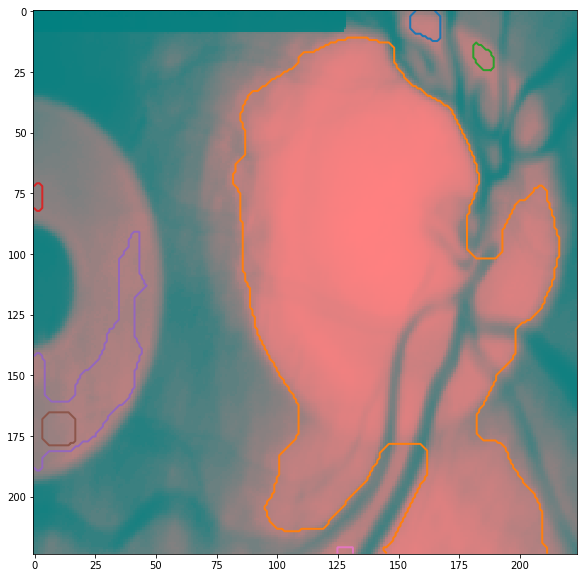

In [24]:
contours = measure.find_contours(opening, 0.8)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(testX[idx], interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)